In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
from pennylane_snowflurry.utility.plotting import graph
from pennylane_snowflurry.utility.debug import SnowflurryUtility, arbitrary_circuit
from pennylane_snowflurry.processing import PreProcessor
from pennylane_snowflurry.processing.config import MonarqDefaultConfig
from pennylane_snowflurry.processing.steps import VF2
from pennylane_snowflurry.API.adapter import ApiAdapter
from pennylane_snowflurry.API.client import MonarqClient
from dotenv import dotenv_values

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\__init__.py:200: PennyLaneDeprecationWarning: Device will no longer be accessible top level. Please access the class as pennylane.devices.LegacyDevice
  warn(


In [11]:
env = dotenv_values(".env")

dev = qml.device("default.qubit", shots=1000)

def circuit(size : int):
    qml.Hadamard(0)
    for n in range(0, size - 1):
        qml.CNOT([n, n + 1])
    
    return qml.counts(wires=[i for i in range(size)])

In [4]:
client = MonarqClient(env["HOST"], env["USER"], env["ACCESS_TOKEN"])
ApiAdapter.initialize(client)

def transpile_snowflurry(tape):
    snowflurryUtil = SnowflurryUtility(tape, 
                                       env["HOST"], 
                                       env["USER"], 
                                       env["ACCESS_TOKEN"], 
                                       "calculqc")
    snowflurryUtil.transpile()
    return snowflurryUtil.to_pennylane()

def transpile_calculqc(tape, config):
    transpiler = PreProcessor.get_processor(config, [w for w in tape.wires])
    return transpiler(tape)[0][0]


In [17]:
qty_from = 3
qty_to = 24
datas = {
    #"snowflurry" : [], 
    "calculqc" : []
}

for i in range(qty_from, qty_to):
    qnode = qml.QNode(lambda: circuit(i), dev)
    qnode()
    # sf_tape = transpile_snowflurry(qnode.tape)
    
    config = MonarqDefaultConfig(use_benchmark=False)
    config.steps[2] = VF2(False)
    cq_tape = transpile_calculqc(qnode.tape, config)
    print(f"{i} : {len(cq_tape.operations)} ops, wires={[w for w in cq_tape.wires]}")
    # sf_node = qml.QNode(lambda : arbitrary_circuit(sf_tape, qml.counts), dev)
    cq_node = qml.QNode(lambda : arbitrary_circuit(cq_tape, qml.counts), dev)
    
    # sf_resources = qml.specs(sf_node)()["resources"]
    cq_resources = qml.specs(cq_node)()["resources"]
    
    # datas["snowflurry"].append(sf_resources.depth)
    datas["calculqc"].append(cq_resources.depth)

3 : 9 ops, wires=[0, 4, 8]
4 : 13 ops, wires=[0, 4, 8, 12]


c:\Users\bouch\AppData\Local\Programs\Python\Python312\Lib\site-packages\pennylane\gradients\gradient_transform.py:265: UserWarning: Attempted to compute the gradient of a tape with no trainable parameters. If this is unintended, please mark trainable parameters in accordance with the chosen auto differentiation framework, or via the 'tape.trainable_params' property.
  warnings.warn(_no_trainable_grad_warning)


5 : 17 ops, wires=[0, 4, 8, 12, 9]
6 : 21 ops, wires=[0, 4, 8, 12, 9, 5]
7 : 25 ops, wires=[0, 4, 8, 12, 9, 5, 1]
8 : 29 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6]
9 : 33 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10]
10 : 37 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13]
11 : 41 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17]
12 : 45 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 20]
13 : 49 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 20, 16]
14 : 53 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 21, 18, 14]
15 : 57 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 21, 18, 14, 11]
16 : 61 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 21, 18, 14, 11, 7]
17 : 65 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 21, 18, 14, 11, 7, 3]
18 : 69 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 21, 18, 14, 11, 15, 19, 22]
19 : 73 ops, wires=[0, 4, 8, 12, 9, 5, 2, 6, 10, 13, 17, 21, 18, 14, 19, 15, 11, 7, 3]
20 : 77 ops, wires=[16, 12, 8, 4, 1, 5, 9, 13, 10, 6, 3, 7, 11, 14, 19, 22, 18, 21, 17, 2

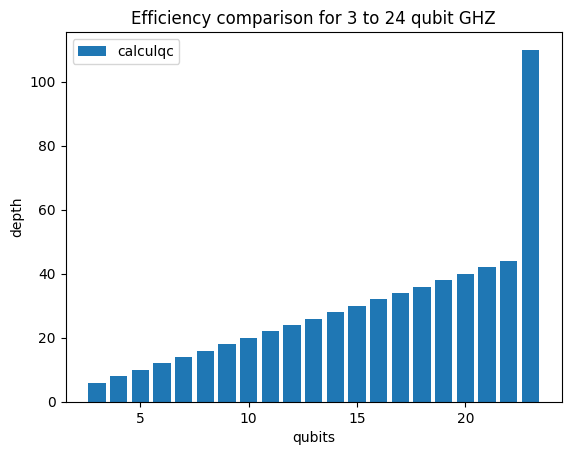

In [15]:
x_labels = np.arange(qty_from, qty_to)

graph(plt.bar, datas, x_labels, "Efficiency comparison for 3 to 24 qubit GHZ", "qubits", "depth")